In [1]:
import tensorflow as tf
import numpy as np
from model.filter import filtfilt
import os
import scipy
import scipy.io as io
import scipy.signal as signal
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 12, 8

In [2]:
fs = 300.

def getvar(constant, **kwargs):
    return tf.Variable(constant, trainable=False, dtype=tf.float32, **kwargs)

In [3]:
tf.reset_default_graph()

y = tf.placeholder(tf.float32, shape=[None], name='input')

with tf.name_scope('lowpass'):
    b_LPF = getvar([0.03125, 0, 0, 0, 0, 0, -0.0625, 0, 0, 0, 0, 0, 0.03125])
    a_LPF = getvar([1.0, -1.99, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    y_LP = filtfilt(b_LPF, a_LPF, y)

with tf.name_scope('highpass'):
    b_HPF = getvar([-1. / 32] + [0] * 15 + [1, -1] + [0] * 14 + [1. / 32])
    a_HPF = getvar([1., -0.99] + [0] * 31)
    y_HP = filtfilt(b_HPF, a_HPF, y)

with tf.name_scope('diff'):
    b_DEV = getvar([1/4, 1/8, 0, -1/8, -1/4])
    a_DEV = getvar([1, 0, 0, 0, 0])
    y_DEV = filtfilt(b_DEV, a_DEV, y_HP)

with tf.name_scope('power1'):
    y_SQ = y_DEV * y_DEV

with tf.name_scope('smoothing'):
    b_SM = getvar([1 / 30] * 30)
    a_SM = getvar([1] + [0] * 30)
    y_SM = filtfilt(b_SM, a_SM, y_SQ)
    #y_SM = filtfilt(b_SM, a_SM, y_SM)

with tf.name_scope('power2'):
    y_PT = (y_HP ** 3) / 200000.


In [4]:
N = 200
#y_val = np.sin(np.arange(N, dtype=np.float32)/3.14)*60 + np.random.randn(N)*60
def loadmat(id):
    fname = "data/raw/training2017/A%05d.mat"%id
    y_val = io.loadmat(fname)['val'][0]
    return y_val

y_val = loadmat(1)

In [10]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    res = y_PT.eval({y:y_val}).squeeze()

<IPython.core.display.Javascript object>


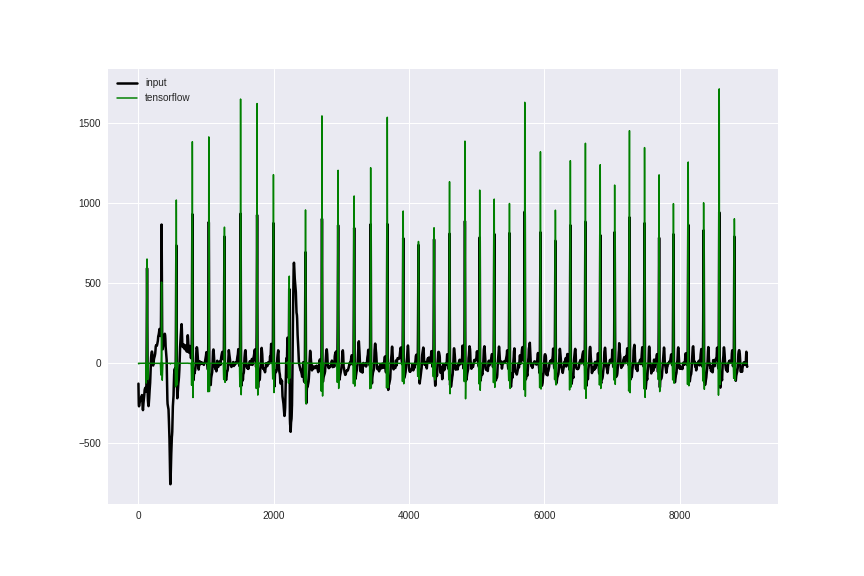

In [23]:
plt.figure(1)
%matplotlib notebook
plt.plot(y_val, 'k-', label='input', linewidth=2.5)
plt.plot(res, 'g-', linewidth=1.5, label='tensorflow')
plt.legend(loc='best')

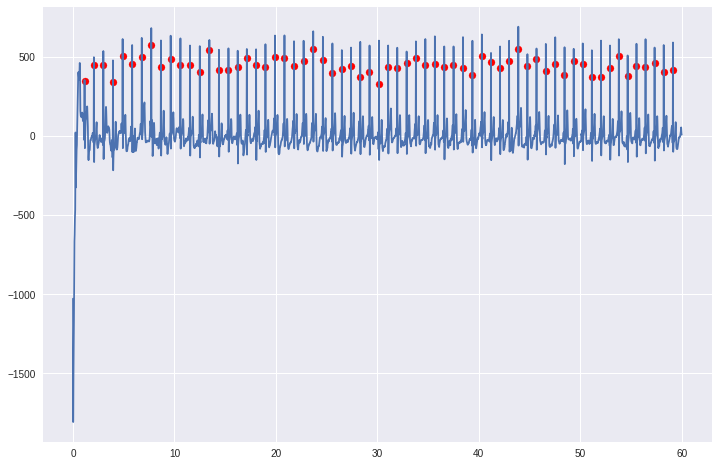

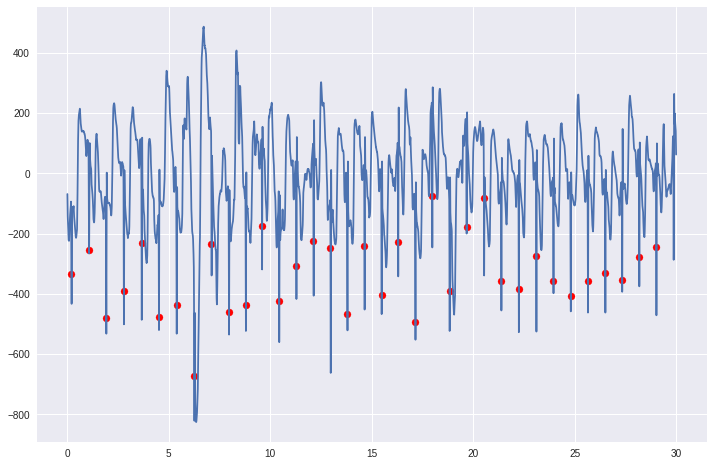

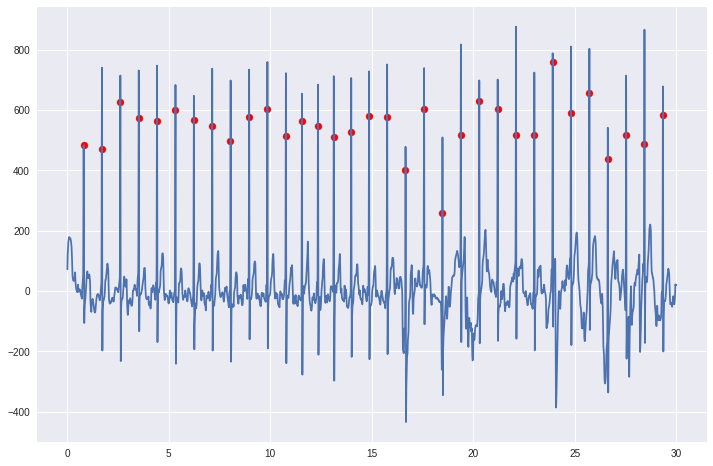

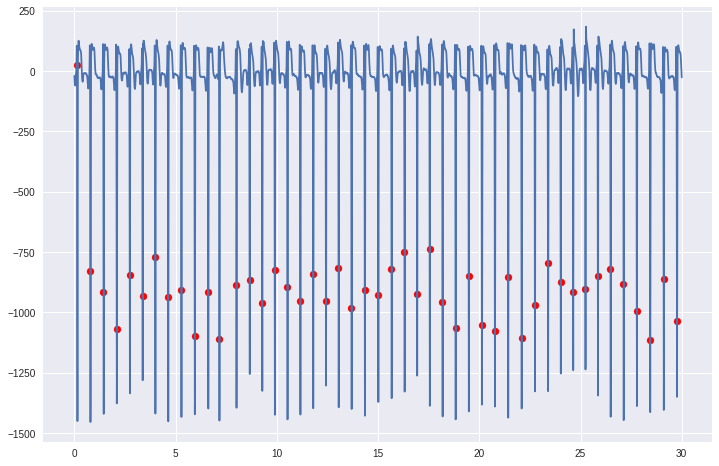

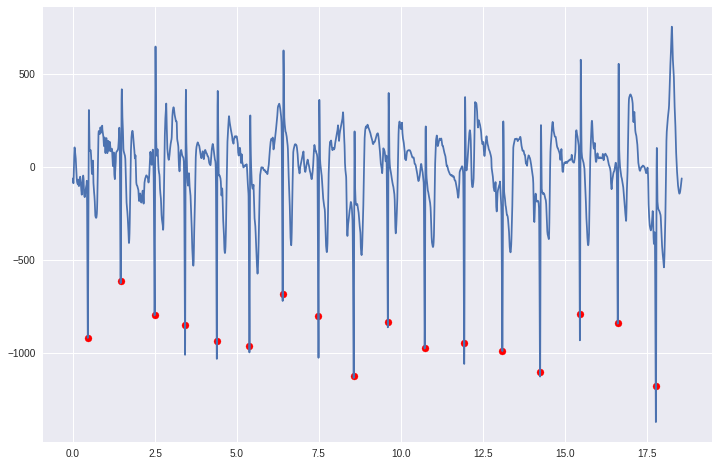

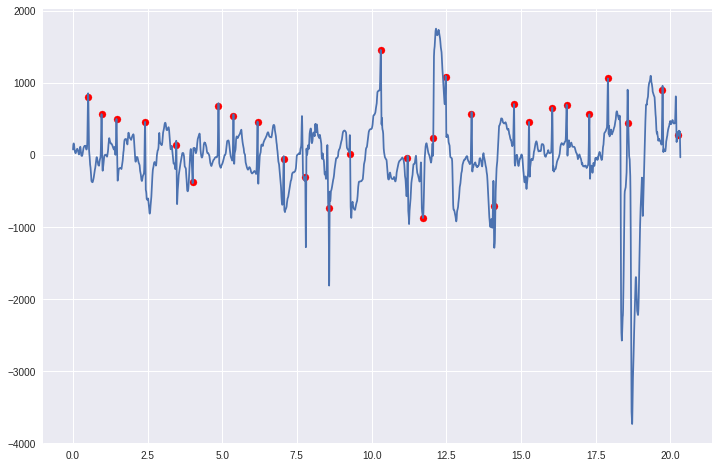

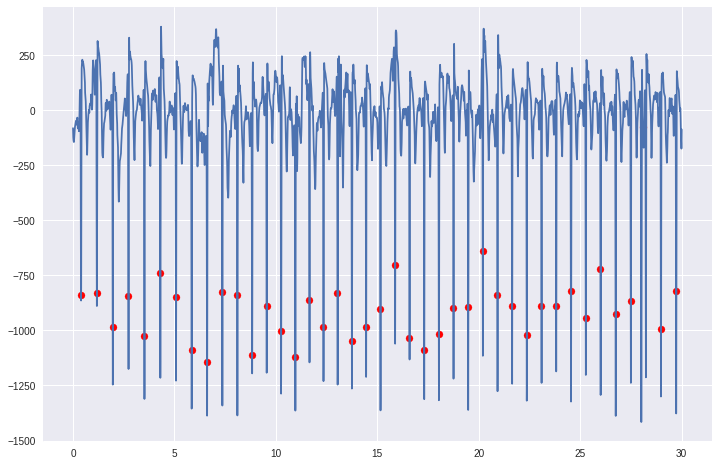

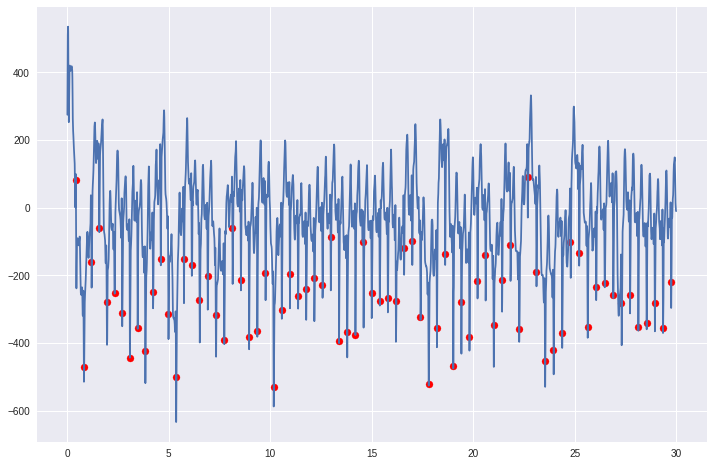

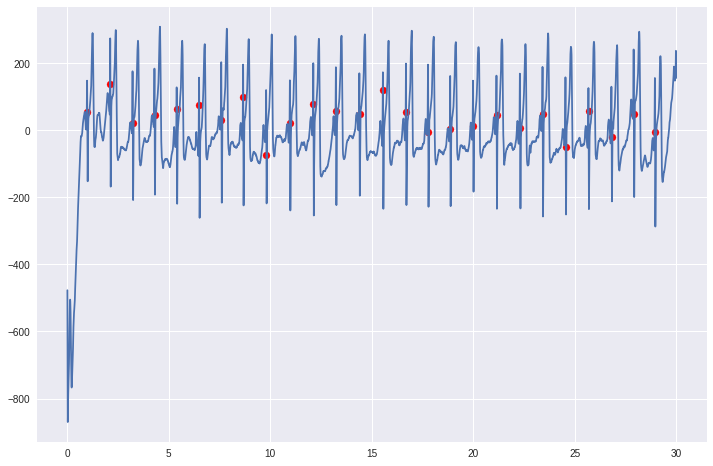

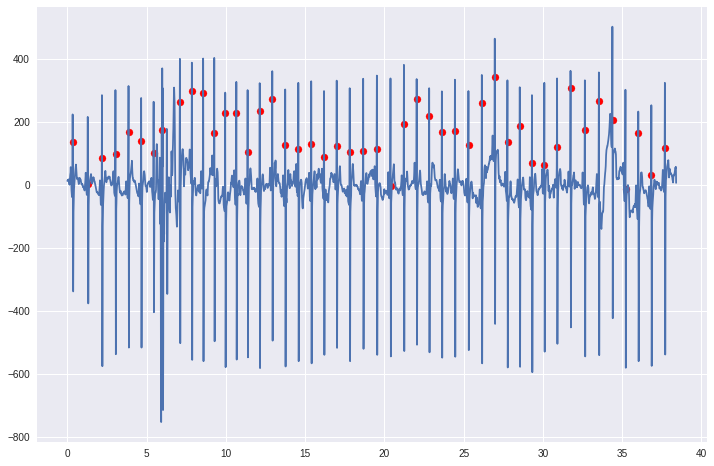

In [5]:
def detect_beats(
        ecg,    # The raw ECG signal
        rate,    # Sampling rate in HZ
        # Window size in seconds to use for 
        ransac_window_size=5.0,
        # Low frequency of the band pass filter
        lowfreq=5.0,
        # High frequency of the band pass filter
        highfreq=15.0,
        ):
    """
    ECG heart beat detection based on
    http://link.springer.com/article/10.1007/s13239-011-0065-3/fulltext.html
    with some tweaks (mainly robust estimation of the rectified signal
    cutoff threshold).
    """

    ransac_window_size = int(ransac_window_size*rate)

    lowpass = scipy.signal.butter(1, highfreq/(rate/2.0), 'low')
    highpass = scipy.signal.butter(1, lowfreq/(rate/2.0), 'high')
    # TODO: Could use an actual bandpass filter
    ecg_low = scipy.signal.filtfilt(*lowpass, x=ecg)
    ecg_band = scipy.signal.filtfilt(*highpass, x=ecg_low)
    
    # Square (=signal power) of the first difference of the signal
    decg = np.diff(ecg_band)
    decg_power = decg**2
    
    # Robust threshold and normalizator estimation
    thresholds = []
    max_powers = []
    for i in range(len(decg_power)//ransac_window_size):
        sample = slice(i*ransac_window_size, (i+1)*ransac_window_size)
        d = decg_power[sample]
        thresholds.append(0.5*np.std(d))
        max_powers.append(np.max(d))

    threshold = 0.5*np.std(decg_power)
    threshold = np.mean(thresholds)
    max_power = np.mean(max_powers)
    decg_power[decg_power < threshold] = 0

    decg_power /= max_power
    decg_power[decg_power > 1.0] = 1.0
    square_decg_power = decg_power**2 + 1e-10
    #plt.plot(square_decg_power)
    shannon_energy = -square_decg_power*np.log(square_decg_power)
    #plt.plot(shannon_energy)
    shannon_energy[~np.isfinite(shannon_energy)] = 0.0

    mean_window_len = int(rate*0.125+1)
    lp_energy = np.convolve(shannon_energy, [1.0/mean_window_len]*mean_window_len, mode='same')
    #lp_energy = scipy.signal.filtfilt(*lowpass2, x=shannon_energy)
    
    lp_energy = scipy.ndimage.gaussian_filter1d(lp_energy, rate/8.0)
    lp_energy_diff = np.diff(lp_energy)

    zero_crossings = (lp_energy_diff[:-1] > 0) & (lp_energy_diff[1:] < 0)
    zero_crossings = np.flatnonzero(zero_crossings)
    zero_crossings -= 1
    return zero_crossings
def plot_peak_detection(ecg, rate):
    import matplotlib.pyplot as plt
    dt = 1.0/rate
    t = np.linspace(0, len(ecg)*dt, len(ecg))
    plt.plot(t, ecg)

    peak_i = detect_beats(ecg, rate)
    plt.scatter(t[peak_i], ecg[peak_i], color='red')
    plt.show()
#db = detect_beats(y_val, 300)
for i in range(10, 20):
    plot_peak_detection(loadmat(i), 300)

In [6]:
BPMs = []
for i in range(1, 8500):
    y_val = loadmat(i)
    db = detect_beats(y_val, fs)
    BPM = len(db) * 60 / (len(y_val) / fs)
    BPMs.append(BPM)
    print('\r%d  mean BPM %f'%(i, np.mean(BPMs)), flush=True, end='')

8499  mean BPM 73.795748

(array([  3.00000000e+00,   5.00000000e+00,   6.00000000e+00,
          5.00000000e+00,   6.00000000e+00,   6.00000000e+00,
          3.00000000e+00,   3.00000000e+00,   7.00000000e+00,
          1.50000000e+01,   2.50000000e+01,   5.30000000e+01,
          1.50000000e+02,   3.35000000e+02,   6.14000000e+02,
          8.42000000e+02,   9.81000000e+02,   1.11700000e+03,
          9.67000000e+02,   8.10000000e+02,   6.79000000e+02,
          4.60000000e+02,   3.69000000e+02,   2.50000000e+02,
          1.32000000e+02,   1.49000000e+02,   9.70000000e+01,
          8.40000000e+01,   5.50000000e+01,   5.00000000e+01,
          4.10000000e+01,   2.80000000e+01,   2.60000000e+01,
          3.10000000e+01,   1.90000000e+01,   2.10000000e+01,
          1.70000000e+01,   8.00000000e+00,   9.00000000e+00,
          4.00000000e+00,   3.00000000e+00,   1.00000000e+00,
          5.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          2.00000000e+00,   2.00000000e+00,   1.00000000e+00,
        

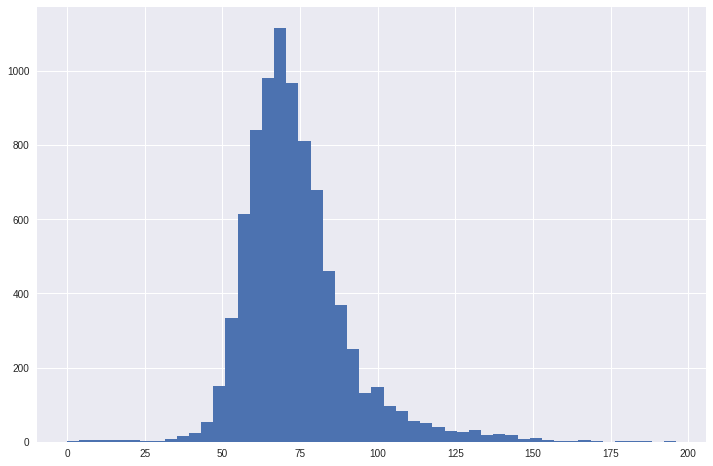

In [7]:
plt.hist(BPMs, bins=50)

In [83]:
def read_raw(refname, dir):
    label_dict = {
        'N': 0,
        'A': 1,
        'O': 2,
        '~': 3
    }

    data = []
    label = []
    lens = []
    annotations = open(refname, 'r').read().splitlines()
    for i, line in enumerate(annotations, 1):
        fname, label_str = line.split(',')
        location = os.path.normpath(dir + '/' + fname + '.mat')
        x = io.loadmat(location)['val'].astype(np.float32).squeeze()
        data.append(x)
        y = label_dict[label_str]
        label.append(y)
        lens.append(len(x))
        if i % 50 == 0:
            print('\rReading files: %5d   ' % i, end='', flush=True)

    print('\rReading files: %5d   ' % i, end='', flush=True)
    assert(len(label) == len(data) == len(lens))
    print('\nReading successful!')
    data_size = len(data)
    data = np.array(data)
    label = np.array(label)
    lens = np.array(lens)
    class_hist = np.histogram(label, bins=len(label_dict))[0]

    return data, label
data, label = read_raw('./data/raw/training2017/REFERENCE.csv', './data/raw/training2017/')

Reading files:  8528   
Reading successful!


In [96]:
BPMs[1]

62.0

In [ ]:
#plt.hist(BPMs, bins=30)
BPMs = np.array(BPMs)
maybe_fibrillation = np.argwhere(BPMs > 150)
for sample_id in maybe_fibrillation[:10]:
    print(BPMs[sample_id], label[sample_id])
    y_val = loadmat(sample_id+1)
    y_norm = signal.resample(y_val, len(y_val)//int(BPMs[sample_id])*72)
    plot_peak_detection(y_norm[:1000], fs)

In [21]:
def testMarci(y0):

    ## import signal
    fs = 300.
    # PT algorithm

    # LP filter
    b_LPF = [1. / 32] + [0] * 5 + [-1. / 16] + [0] * 5 + [1. / 32]
    a_LPF = [1., -1.99, 1.] + [0] * 10
    y_LP = signal.filtfilt(b_LPF, a_LPF, y0)

    # HP Filter
    b_HPF = [-1. / 32] + [0] * 15 + [1, -1] + [0] * 14 + [1. / 32]
    a_HPF = [1., -0.99] + [0] * 31
    y_HP = signal.filtfilt(b_HPF, a_HPF, y0)

    # Differentiation
    b_DEV = [1. / 4, 1. / 8, 0, -1. / 8, -1. / 4]
    a_DEV = [1] + [0] * 4
    y_DEV = signal.filtfilt(b_DEV, a_DEV, y_HP)

    # Squaring
    y_SQ = y_DEV * y_DEV

    # Smoothing
    b_SM = [1. / 30] * 30
    a_SM = [1] + [0] * 30
    y_SM1 = signal.filtfilt(b_SM, a_SM, y_SQ)
    y_SM2 = signal.filtfilt(b_SM, a_SM, y_SM1)

    # PT Squaring
    y_QRS = (y_HP * y_HP * y_HP) / 200000.
    y_PT = np.asarray(y0)
    
    return y_SM2

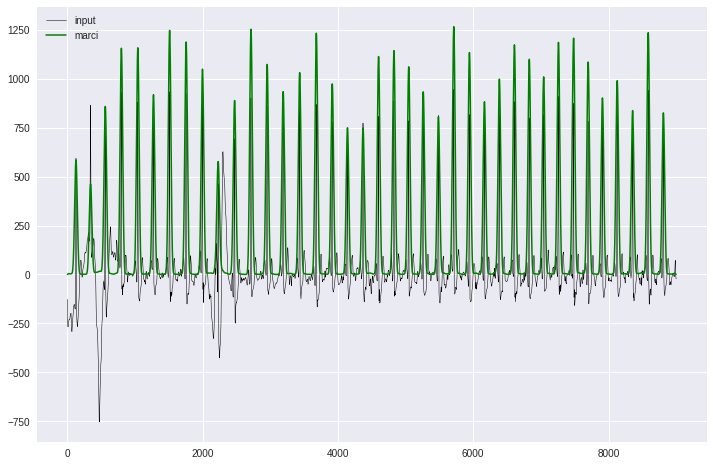

In [22]:
marci_res = testMarci(y_val)
plt.figure(1)
plt.plot(y_val, 'k-', label='input', linewidth=0.5)
plt.plot(marci_res, 'g-', linewidth=1.5, label='marci')
plt.legend(loc='best')
plt.show()

In [110]:
# [sequnce_length]
x_single = tf.placeholder(tf.float32, shape=[None], name='x_vector')
# [filter_length(N/M), num_filters]
a = tf.placeholder(tf.float32, shape=[None], name='a_vector')
b = tf.placeholder(tf.float32, shape=[None], name='b_vector')
X = np.arange(10, dtype=np.float32)

A = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 1])
B = np.array([1, 0, 0])

test_op = filtfilt(b, a, x_single)
test_feed = {
    b: B,
    a: A,
    x_single: X
}
with tf.Session() as sess:
    res = sess.run(test_op, test_feed).squeeze()
    
res

InvalidArgumentError: Incompatible shapes: [1,8,1] vs. [1,9,1]
	 [[Node: while_4/mul_1 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](while_4/strided_slice_1, while_4/mul_1/y)]]

Caused by op 'while_4/mul_1', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2683, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2787, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2847, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-110-11510c5ff77c>", line 11, in <module>
    test_op = filtfilt(b, a, x_single)
  File "/home/csbotos/af_challenge_itk/tensorflow/model/filter.py", line 71, in filtfilt
    filt = lfilt(b, a, x)
  File "/home/csbotos/af_challenge_itk/tensorflow/model/filter.py", line 64, in lfilt
    parallel_iterations=1, back_prop=False)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/control_flow_ops.py", line 2623, in while_loop
    result = context.BuildLoop(cond, body, loop_vars, shape_invariants)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/control_flow_ops.py", line 2456, in BuildLoop
    pred, body, original_loop_vars, loop_vars, shape_invariants)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/control_flow_ops.py", line 2406, in _BuildLoop
    body_result = body(*packed_vars_for_body)
  File "/home/csbotos/af_challenge_itk/tensorflow/model/filter.py", line 54, in body
    y_curr = prod(x_padded[:, t:t + N:], [b]) - prod(y[:, -M:], [a])
  File "/home/csbotos/af_challenge_itk/tensorflow/model/filter.py", line 51, in prod
    return tf.reduce_sum(a * b, axis=1, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_ops.py", line 821, in binary_op_wrapper
    return func(x, y, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_ops.py", line 1044, in _mul_dispatch
    return gen_math_ops._mul(x, y, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_math_ops.py", line 1434, in _mul
    result = _op_def_lib.apply_op("Mul", x=x, y=y, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Incompatible shapes: [1,8,1] vs. [1,9,1]
	 [[Node: while_4/mul_1 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](while_4/strided_slice_1, while_4/mul_1/y)]]
